In [5]:
from load_modules import *
import my_config
import time
# conda create --name tf_gpu tensorflow-gpu
# conda activate tf_gpu
# pip install pandas scikit-learn matplotlib colorspacious ipykernel
# pip install opencv-python pandas scikit-learn matplotlib colorspacious 
# os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [2]:
if my_config.USE_GPU:
    physical_devices = tf.config.list_physical_devices('GPU')
    #set memory amount to half of GPU
    if len(physical_devices) > 0:
        for device in physical_devices:
            print("Device:", device)
    else:
        print("No GPU devices found.")
    # Set GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                
        except RuntimeError as e:
            print(e)
        # Set environment variable for GPU memory allocation

    # Test for GPU device name
    name = tf.test.gpu_device_name()
    if name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(name))
    # Print the number of available GPUs
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU")

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [6]:
image_paths = os.listdir(my_config.IMAGE_FOLDER)
images = []
names = []
for image_path in image_paths:
    folder_name = image_path.split('.')[0]
    names.append(folder_name)
    image_path = os.path.join(my_config.IMAGE_FOLDER, image_path)
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    if np.max(image) > 1:
        image = image/255.0
    images.append(image)
print(names)
all_model_paths = []
print(my_config.IMAGE_FOLDER)
print(my_config.ENCODER_PATH)
print(my_config.DECODER_PATH)

encoder = load_model(my_config.ENCODER_PATH)
decoder = load_model(my_config.DECODER_PATH)
print("Loaded models")
print("Encoder summary:" + str(encoder.summary()))
print("Decoder summary:" + str(decoder.summary()))
def encode(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    pred_maps = None
    with tf.device('/device:GPU:0'):
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    recovered = None
    with tf.device('/device:GPU:0'):
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
    WIDTH = original.shape[0]
    HEIGHT = original.shape[1]
    # Convert the images to the CAM02-UCS color space and calculate the delta E loss
    if original.shape[0] != recovered.shape[0] or original.shape[1] != recovered.shape[1]:
        print("original shape:", original.shape)
        print("recovered shape:", recovered.shape)
        print("original and recovered shape do not match")
        original = original.reshape((WIDTH, HEIGHT, 3))
        recovered = recovered.reshape((WIDTH, HEIGHT, 3))
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    # Plot the delta E loss in the third subplot
    return delta_e

['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k', 'metina']
models_4k
C:\Users\joeli\OneDrive\Desktop\AE_2023_06\TrainedModels\no_duplicates_75_2_mask\encoder.h5
C:\Users\joeli\OneDrive\Desktop\AE_2023_06\TrainedModels\no_duplicates_75_2_mask\decoder.h5
Loaded models
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 3)]               0         
                                                                 
 encoder_dense_1 (Dense)     (None, 75)                300       
                                                                 
 encoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 decoder_output (Dense)      (None, 5)                 380       
                                                                 
Total params: 6,380
Trainable params: 6,380
Non-train

shape of pred_maps: (16777216, 5)
Cm min: -0.09067060053348541 Cm mean: -0.025466948747634888| Cm max: 0.5266836881637573 | Ch min: -0.06259490549564362 Ch mean: 0.15528318285942078| Ch max: 0.3612698018550873 | T min: 0.0914558619260788 T mean: 0.19052644073963165| T max: 0.22406068444252014 | Bm min: 0.4360649287700653 Bm mean: 0.563357412815094| Bm max: 0.6224231719970703 | Bh min: 0.38075363636016846 Bh mean: 0.5475549697875977| Bh max: 0.7719553112983704
shape of recovered: (16777216, 3)


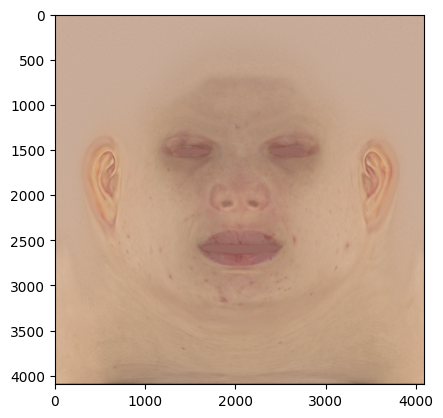

size of image: (4096, 4096, 3)
max pixel value: 0.9018102288246155
min pixel value: 0.06848166882991791
shape of pred_maps: (16777216, 5)
Cm min: 0.03031618893146515 Cm mean: 0.14102984964847565| Cm max: 0.5293675661087036 | Ch min: 0.05576474219560623 Ch mean: 0.1557149589061737| Ch max: 0.33044102787971497 | T min: 0.10218499600887299 T mean: 0.16218803822994232| T max: 0.20052385330200195 | Bm min: 0.44308632612228394 Bm mean: 0.4764951467514038| Bm max: 0.5228565335273743 | Bh min: 0.47172677516937256 Bh mean: 0.5760785937309265| Bh max: 0.7700801491737366
shape of recovered: (16777216, 3)


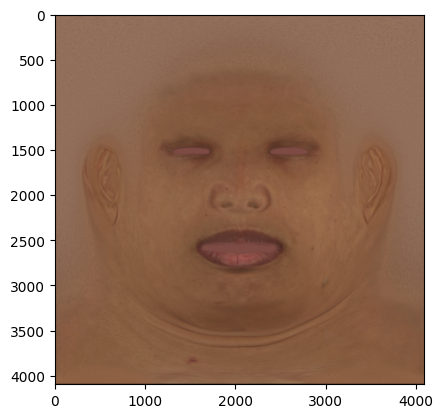

size of image: (4096, 4096, 3)
max pixel value: 0.6797565221786499
min pixel value: 0.056485142558813095
shape of pred_maps: (16777216, 5)
Cm min: -0.04619775712490082 Cm mean: 0.033360544592142105| Cm max: 0.5279947519302368 | Ch min: -0.044905923306941986 Ch mean: 0.08708681166172028| Ch max: 0.32376718521118164 | T min: 0.08136752992868423 T mean: 0.16012069582939148| T max: 0.21272453665733337 | Bm min: 0.42569372057914734 Bm mean: 0.5130996108055115| Bm max: 0.577954888343811 | Bh min: 0.4166836142539978 Bh mean: 0.6052102446556091| Bh max: 0.7940795421600342
shape of recovered: (16777216, 3)


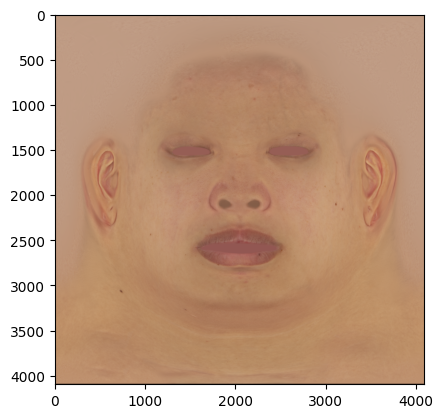

size of image: (4096, 4096, 3)
max pixel value: 0.9636020064353943
min pixel value: 0.07095707952976227
shape of pred_maps: (16777216, 5)
Cm min: -0.011064320802688599 Cm mean: 0.3029187321662903| Cm max: 0.5266836881637573 | Ch min: 0.11736493557691574 Ch mean: 0.2483275830745697| Ch max: 0.4114627540111542 | T min: 0.13075008988380432 T mean: 0.168785959482193| T max: 0.21979272365570068 | Bm min: 0.4494245648384094 Bm mean: 0.4969332814216614| Bm max: 0.5496851801872253 | Bh min: 0.3787422776222229 Bh mean: 0.5824660658836365| Bh max: 0.7002184391021729
shape of recovered: (16777216, 3)


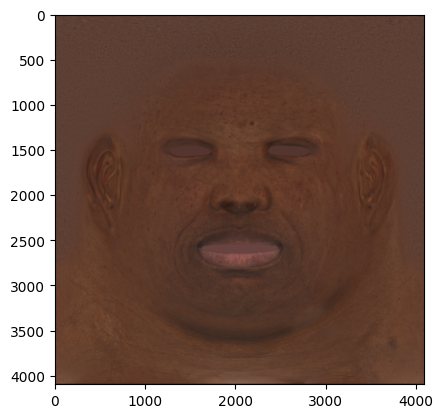

size of image: (4096, 4096, 3)
max pixel value: 0.6577315330505371
min pixel value: 0.05538719892501831
shape of pred_maps: (16777216, 5)
Cm min: 0.018398404121398926 Cm mean: 0.43174177408218384| Cm max: 0.5279947519302368 | Ch min: 0.1831764280796051 Ch mean: 0.343331903219223| Ch max: 0.4455784857273102 | T min: 0.14874063432216644 T mean: 0.17902274429798126| T max: 0.23745854198932648 | Bm min: 0.48591747879981995 Bm mean: 0.5173515677452087| Bm max: 0.5476803779602051 | Bh min: 0.314908504486084 Bh mean: 0.5216959118843079| Bh max: 0.6502593755722046
shape of recovered: (16777216, 3)


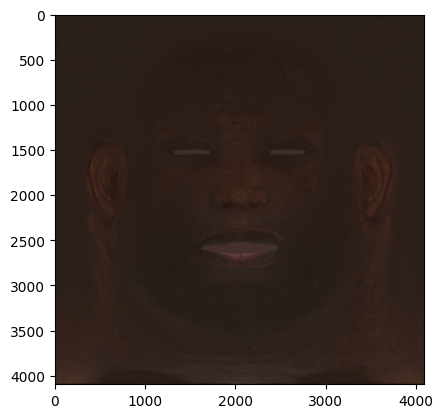

size of image: (4096, 4096, 3)
max pixel value: 0.5553346276283264
min pixel value: 0.055259399116039276
shape of pred_maps: (16777216, 5)
Cm min: -0.07344205677509308 Cm mean: 0.00025764695601537824| Cm max: 0.5276889801025391 | Ch min: -0.005287729203701019 Ch mean: 0.20250250399112701| Ch max: 0.4907849431037903 | T min: 0.11217048764228821 T mean: 0.19594454765319824| T max: 0.24988329410552979 | Bm min: 0.4376147389411926 Bm mean: 0.5467820763587952| Bm max: 0.5960499048233032 | Bh min: 0.33448201417922974 Bh mean: 0.5103890895843506| Bh max: 0.7126457095146179
shape of recovered: (16777216, 3)


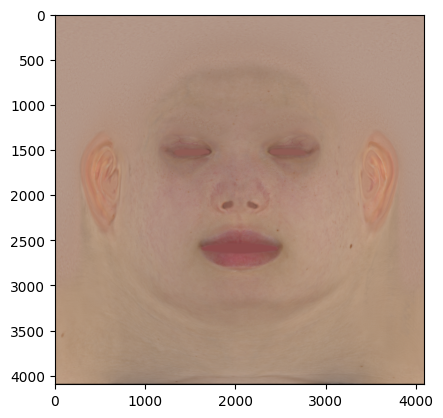

size of image: (4096, 4096, 3)
max pixel value: 0.8246098160743713
min pixel value: 0.06891971081495285


In [8]:
# fig,ax = plt.subplots(5,5, figsize=(16,14))
subjects_meta = ['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k']
idx = 0

for image, folder_name in zip(images, names):
    WIDTH = image.shape[0]
    HEIGHT = image.shape[1]
    image = np.asarray(image)
    image_numpy = image.reshape((WIDTH, HEIGHT, 3))
    pred_maps, encode_time = encode(image_numpy)
    print(f"shape of pred_maps: {pred_maps.shape}")
    Cm = np.asarray(pred_maps[:,0])
    Ch = np.asarray(pred_maps[:,1])
    Bm = np.asarray(pred_maps[:,2])
    Bh = np.asarray(pred_maps[:,3])
    T = np.asarray(pred_maps[:,4])
    av_T = np.mean(T)
    max_T = np.max(T)
    min_T = np.min(T)
    av_Cm = np.mean(Cm)
    max_Cm = np.max(Cm)
    min_Cm = np.min(Cm)
    av_Ch = np.mean(Ch)
    max_Ch = np.max(Ch)
    min_Ch = np.min(Ch)
    min_Bm = np.min(Bm)
    max_Bm = np.max(Bm)
    av_Bm = np.mean(Bm)
    min_Bh = np.min(Bh)
    max_Bh = np.max(Bh)
    av_Bh = np.mean(Bh)
    # result_string = f"Cm: {av_Cm}, {max_Cm}, {min_Cm} | Ch: {av_Ch}, {max_Ch}, {min_Ch} | T: {av_T}, {max_T}, {min_T} | delta_e: {av_delta_e}, {max_delta_e}, {min_delta_e}"
    result_string = f"Cm min: {min_Cm} Cm mean: {av_Cm}| Cm max: {max_Cm} | Ch min: {min_Ch} Ch mean: {av_Ch}| Ch max: {max_Ch} | T min: {min_T} T mean: {av_T}| T max: {max_T} | Bm min: {min_Bm} Bm mean: {av_Bm}| Bm max: {max_Bm} | Bh min: {min_Bh} Bh mean: {av_Bh}| Bh max: {max_Bh}"
    print(result_string)
    # pred_maps[:,0] = Cm*0.9
    # pred_maps[:,1] = Ch*0.9
    # pred_maps[:,2] = Bm
    # pred_maps[:,3] = Bh*0.8
    # pred_maps[:,4] = T*0.9
    recovered, decode_time = decode(pred_maps)
    print(f"shape of recovered: {recovered.shape}")
    recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))
    # recovered_lab= colorspacious.cspace_convert(recovered, 'sRGB1', 'CAM02-UCS')
    # recovered = np.asarray(decoded_increased_Cm).reshape((WIDTH, HEIGHT, 3))
    plt.imshow(recovered)
    plt.show()
    #save the image 
    #print size of image
    print(f"size of image: {recovered.shape}")
    #max min pixel values
    print(f"max pixel value: {np.max(recovered)}")
    print(f"min pixel value: {np.min(recovered)}")
    #clamp the values to 0-1
    recovered = np.clip(recovered, 0, 1)
    # experiment_name = input("Enter experiment name: ")
    # file_NAME = f"{experiment_name}_{subjects_meta[idx]}.png"
    # plt.imsave(file_NAME, recovered)
    idx += 1
    